# Поиск похожих текстов

**Идея:** найти пословицу (в другой версии документа это было стихотворение), наиболее близкое по смыслу к новостям дня - то есть проиллюстрировать новости "художественным словом".

**Цель:** учебный проект для тренировки навыков в обработке текстов, создании плотных векторных представлений, работе с полученными матрицами

**Задачи:**

1. При помощи простого парсера собрать новостные тексты
2. Собрать короткие художественные тексты - в текущей версии документа это пословицы и поговорки, также эксперимент проводился со сборником стихотворений русских поэтов
3. Предобработать тексты - вычистить от малоинформативных слов, пунктуации, токенизировать и привести слова к начальной форме.
4. Получить плотные векторные представления
5. Вычислив минимальное косинусное расстояние между векторами текстов новостей и художественных текстов, найти то произведение, которое лучше всего отражает смысл актуальных новостей
6. Вывести найденный текст и ключевые слова новостей, чтобы оценить результаты эксперимента

### 1. Импорт библиотек и модулей, назначение констант

In [1]:
import re
import string
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

from wordcloud import WordCloud #visualization
import matplotlib.pyplot as plt

In [2]:
!pip install nltk

import nltk
nltk.download('word_tokenize')
nltk.download('punkt')
nltk.download('stopwords')

from nltk import word_tokenize #чтобы поделить текст на токены
from nltk import ngrams
from nltk.corpus import stopwords

from pymystem3 import Mystem
mystem_analyzer = Mystem()

from nltk.probability import FreqDist #чтобы посчитать частоту

!pip install pymorphy3
!pip install navec

import pymorphy3
from navec import Navec

!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar -O navec_hudlit_v1_12B_500K_300d_100q.tar
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

nltk.download('punkt')

[nltk_data] Error loading word_tokenize: Package 'word_tokenize' not
[nltk_data]     found in index
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 53.2 MB/s eta 0:00:00
--2024-04-01 20:56:55--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  10.1MB/s    in 7.0s    

2024-04-01 20:57:04 (7.26 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [145]:
import warnings
warnings.filterwarnings('ignore')

In [93]:
random_state = 42
max_len = 100
vector_size = 300

### 2. Парсинг новостных текстов

In [4]:
base_url='https://ru.euronews.com'

def search (day):
    text=''
    resp=requests.get(base_url+day)

    soup=BeautifulSoup(resp.text)
    article=[]
    link=[]

    for article_tag in soup.find_all('article'):
      h2_tag=article_tag.find('h3')
      new=h2_tag.text.strip()
      text+=(' '+new)

    return text

In [5]:
def get_dates(delta):
    date_format = '/%Y/%m/%d'
    today = datetime.now()-timedelta(days=delta)
    return today.strftime(date_format)

In [7]:
articles_yesterday=search(get_dates(1))
articles_yesterday

' Большой шлем в Анталье: дзюдоисты Франции завоевали три золотые медали Газа: двое погибших в результате авиаудара по двору больницы "Аль-Акса". ЦАХАЛ: целью были боевики Оппозиция лидирует на муниципальных выборах в Турции – подсчитано более 90% голосов В Болгарии и Румынии отметили частичное вступление в Шенген "Граду и миру": папа римский призвал Россию и Украину обменять всех пленных Карл III впервые появился на публике после онкологического диагноза В Токио и Бонне - сезон цветения сакуры Война в Газе: в Каире возобновляются переговоры о перемирии Spitzenkandidaten: демократический инструмент или политическая шарада? Болгария и Румыния стали частью Шенгенской зоны Папа римский Франциск призвал сохранять радость и надежду'

In [8]:
articles_today=search(get_dates(0))
articles_today

' Венгерские пасхальные традиции: в Холлокё женщин обливают водой Шенген соединил Софию и Бухарест Крупный пожар в Екатеринбурге: возгорание ликвидировано, жертв нет Иранское консульство в Дамаске разрушено в результате удара Израиля - СМИ Столкновение под Ярославлем: диспетчер мог быть пьян — губернатор Новости дня | 1 апреля — вечерний выпуск Жара на Кипре: температура воздуха превысила 30°C World Nature Photography Awards 2024: природа в фокусе Израиль вывел войска из больничного комплекса Аш-Шифа в секторе Газа Москва отвергает обвинения в причастности к "гаванскому синдрому" Выборы в Турции: оппозиция одержала победу на местных выборах Пятерка за реактивность: в ЕС позитивно оценили роль Брюсселя в пандемию В Румынии зафиксирован самый теплый конец марта за последние 77 лет Лиссабон: наука и инновации "с человеческим лицом" Сафранболу: город, известный османскими домами и «красным золотом» Франция призывает Китай повлиять на Россию Где в Европе наблюдается наибольшее неравенство в

In [9]:
articles = articles_yesterday + articles_today

### 3. Предобработка текста

Создаем функцию, которая приводит весь текст к одному регистру, токенизирует, убирает пунктуацию, приводит слова к нормальной форме и очищает текст от неинформативных слов

In [123]:
def preprocess(text, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks and token.isalpha():
            lemma = morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return preprocessed_text

In [124]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '.', '..', '...', '«', '»', ';', '–', '--']
morph = pymorphy3.MorphAnalyzer()

In [125]:
nltk.download('stopwords')
stop_words = stopwords.words("russian")
stop_words.extend(['день', 'апрель', 'новость', 'выпуск'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [128]:
articles[:300]

' Большой шлем в Анталье: дзюдоисты Франции завоевали три золотые медали Газа: двое погибших в результате авиаудара по двору больницы "Аль-Акса". ЦАХАЛ: целью были боевики Оппозиция лидирует на муниципальных выборах в Турции – подсчитано более 90% голосов В Болгарии и Румынии отметили частичное вступ'

In [130]:
txt = preprocess(articles, stop_words, punctuation_marks,morph)
print(*txt[:30])

большой шлем анталья дзюдоист франция завоевать золотой медаль газ двое погибнуть результат авиаудар двор больница цахать цель боевик оппозиция лидировать муниципальный выборы турция подсчитать голос болгария румыния отметить частичный вступление


### Обработка художественного текста по тому же алгоритму

In [ ]:
from google.colab import files
files.upload()

In [138]:
#кладем в перемнную текст
TRAIN_TEXT_FILE_PATH = 'posl.txt'

with open(TRAIN_TEXT_FILE_PATH) as text_file:
    text = text_file.readlines()
text = ' '.join(text)

posl=text
print(posl[:300])

﻿     Без людей нет жизни.
      Безумно живому человеку о смерти думать.
      В добром житье лицо белится, в плохом —чернится.
      В жизни все меняется, а еще и не то случается.
      Век долог – всем полон.
      Век живи – век надейся.
      Век живи – век трудись, а трудясь – век учись.
     


Делим текст на отдельные пословицы - в данном документе все просто: каждая пословица это одно предложение, которое заканчивается точкой.

In [139]:
posl=posl.split('.')

In [140]:
print(posl[0])

﻿     Без людей нет жизни


Всего у нас почти 2,5 тысячи коротких текстов

In [141]:
len(posl)

2496

Предобрабатываем текст:

In [142]:
prep_posl = [preprocess(p, punctuation_marks, stop_words, morph) for p in posl]

In [143]:
print(*prep_posl[0])

человек жизнь


### 4. Векторизация текстов при помощи плотных векторных представлений и библиотеки Navec

In [94]:
def vectorize_text(txt, navec, max_len):
    unk = navec['<unk>']
    text_embeddings = []
    for tocken in txt:
        embedding = navec.get(tocken, unk)
        text_embeddings.append(embedding)
    # Дополняем или обрезаем отзывы для фиксированной длины max_review_len
    l = len(text_embeddings)
    if l > max_len:
        text_embeddings = text_embeddings[:max_len]
    else:
        text_embeddings.extend([navec['<pad>']] * (max_len - l))
    return text_embeddings

In [95]:
vec_posl = [vectorize_text(p, navec, max_len) for p in prep_posl]

In [96]:
np.array(vec_posl[0]).shape

(100, 300)

In [97]:
posl_emb = [np.array(e).reshape(vector_size * max_len) for e in vec_posl]

In [98]:
np.array(posl_emb[0]).shape

(30000,)

In [99]:
news_vec = vectorize_text(txt, navec, max_len)
news_vec = np.array(news_vec).reshape(vector_size * max_len)
news_vec.shape

(30000,)

In [100]:
posl_emb_list = [list(p) for p in posl_emb]

In [101]:
news_vec_list=list(news_vec)

### 5. Функция для подсчета векторного расстояния между векторами текстов новостей и художественных текстов

In [102]:
#Евклидово расстояние
d = np.sum([(news_vec[i]-posl_emb[3][i])**2 for i in range(29000)])
d

3215.3474424747274

In [103]:
'''def best_poem(all_poems, news):
  min_dist = 5000
  idx = 0
  for poem in all_poems:
    distance = np.sqrt(np.sum([(news[i]-poem[i])**2 for i in range(len(news))]))
    if distance < min_dist:
      min_dist = distance
      idx = all_poems.index(poem)
  return idx'''

In [144]:
#косинусное расстояние
def best_poem_cos(all_poems, news):
  min_cos = 1
  idx = 0
  for poem in all_poems:
    dot=np.dot(poem, news)
    cos=dot/(np.linalg.norm(poem)*np.linalg.norm(news))
    if cos < min_cos:
      min_cos = cos
      idx = all_poems.index(poem)
  return idx

### 6. Визуализация: сравниваем выведенный текст и ключевые слова, извлеченные из новостей

In [146]:
print(posl[best_poem_cos(posl_emb_list, news_vec_list)])


      От него ни отмолиться, ни отчураться


In [147]:
fdist=FreqDist(txt)
#fdist.most_common(15)

In [148]:
# переводим всё в текстовый формат
text_raw = " ".join(fdist)
# готовим размер картинки
wordcloud = WordCloud(width=560, height=400, max_words=25, background_color="white", colormap='flag', collocations=False).generate(text_raw)

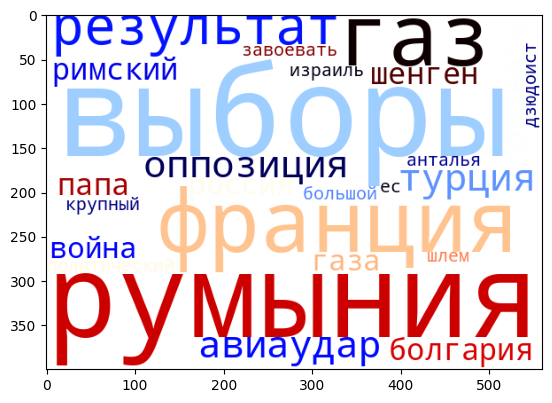

In [149]:
plt.imshow(wordcloud)
#plt.savefig('foo.jpg')

### 7. Выводы:

Поэскпериментировать удалось, результат не такой прекрасный, как хотелось бы. Художественный текст не очень хорошо соотносится по смыслу с новостями. Вот идеи, какие недоработки могли к этому привести, и как улучшить работу:

1. Следует поработать с извлечением именованных сущностей в тексте. Видно, что смысл некоторых слов потерялся (важные смысловые сочетания 'папа римский', 'Сектор Газа' разбились на части и потеряли смысл, 'Цахал' склоняется как глагол и тд)
2. Следует подобрать другие художественные тексты - большего объема, чтобы они были лучше сопоставимы с новостными текстами. Может, стоит вернуться к поэтическим произведениям или еще какому-то формату емких, но не настолько коротких, как пословицы, текстов.
3. Возможно, стоит расширить источник новостей и дописать парсер еще для какого-то ресурса. Предполагаю, что в большем объеме текста будет проще понять, какие темы действительно самые значимые в конкретный день - так как одни и те же события будут упоминаться у каждого источника.
4. В перспективе расширения этой работы также попробовать подать выделенные ключевые слова генеративной модели, чтобы получить иллюстрацию к событиям дня.